In [1]:
import nibabel as nib
import numpy as np
import h5py
import glob
import os
import pandas as pd
from utils.IO import build_dataframe, load_subjects
from utils.ISC import *
from utils.Surf import *
from utils.Vis import *

# Search and filter files

In [2]:
# Get summary of all files
df = build_dataframe('/home/ali/Workspace/EpLink/eplink-p3-parcellated')
# Sort files 
df = df.sort_values(by=['subject', 'task', 'run'], ascending=[True]*3).reset_index()
# Ignore some columns
#['subject', 'task', 'run', 'hemi', 'fwhm', 'confounds', 'n_vol', 'full_path']
df = df[['subject', 'task', 'run', 'hemi', 'n_vol', 'full_path']]
# Print and Save the summary to file
ps = False
if ps:
    print(df)
    df.to_csv('h5files.csv')

In [3]:
n_vols = 384
n_rois = 181

# Ignore files with less than 384 volumes
df = df[df['n_vol'] >= n_vols].reset_index(drop=True)

# Filter tasks: movie and rest
df_movie = df[df['task'] == 'movie'].reset_index(drop=True)
subjects_movie = df_movie['subject'].unique()

df_rest = df[df['task'] == 'rest'].reset_index(drop=True)
subjects_rest = df_rest['subject'].unique()

# Analyze subjects who have both rest and movie sessions
subjects_excluded = set(subjects_movie).symmetric_difference(set(subjects_rest))
subjects_excluded = subjects_excluded.union({'0008', '0009', '0011', '0013', '0018', '5217', '5219', '5222'}) # Manually exclude subjects
print(f'{len(subjects_excluded)} Exluded subjects:', subjects_excluded)

subjects = set(subjects_movie).union(set(subjects_rest)).difference(subjects_excluded)
subjects = sorted(subjects)

# Identify patient and control subjects
patients = [s for s in subjects if s < '5000']
controls = [s for s in subjects if s > '5000']

n_patients = len(patients)
n_controls = len(controls)
n_subjects = len(subjects)

print(f"{n_subjects} subjects: {n_patients} patients + {n_controls} controls")

11 Exluded subjects: {'0036', '0021', '5217', '0011', '0018', '0013', '5222', '0022', '0008', '0009', '5219'}
36 subjects: 18 patients + 18 controls


# Load data for tasks separatly

In [4]:
# Load tasks (rest and movie) separatly for all subjects
data_movie = load_subjects(df_movie, subjects, n_vols)
data_rest = load_subjects(df_rest, subjects, n_vols)

## Leave-One-Out ISC

In [5]:
isc_movie = calculate_ISC(data_movie, range(n_subjects), 'Xloo', n_patients)
isc_rest = calculate_ISC(data_rest, range(n_subjects), 'Xloo', n_patients)

/home/ali/anaconda3/envs/ISC-env/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ali/anaconda3/envs/ISC-env/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

T_movie, pval_movie = dict(), dict()
for h in ['L', 'R']:
    T_movie[h] = []
    pval_movie[h] = []
    for roi in range(180):
        t, p = ttest_ind(isc_movie[f'C{h}'][roi,:], isc_movie[f'X{h}'][roi,:], alternative='greater')
        T_movie[h].append(t)
        pval_movie[h].append(p)

roi2gii(T_movie, './results/', 'ISC_Xloo_movie_tstat')
roi2gii(pval_movie, './results/', 'ISC_Xloo_movie_pval')

T_rest, pval_rest = dict(), dict()
for h in ['L', 'R']:
    T_rest[h] = []
    pval_rest[h] = []
    for roi in range(180):
        t, p = ttest_ind(isc_rest[f'C{h}'][roi,:], isc_rest[f'X{h}'][roi,:], alternative='greater')
        T_rest[h].append(t)
        pval_rest[h].append(p)

roi2gii(T_rest, './results/', 'ISC_Xloo_rest_tstat')
roi2gii(pval_rest, './results/', 'ISC_Xloo_rest_pval')
#sns.histplot(difference.T)

array([0.45164764, 0.8453562 , 0.26221418, ..., 0.3344813 , 0.3344813 ,
       0.3344813 ], dtype=float32)

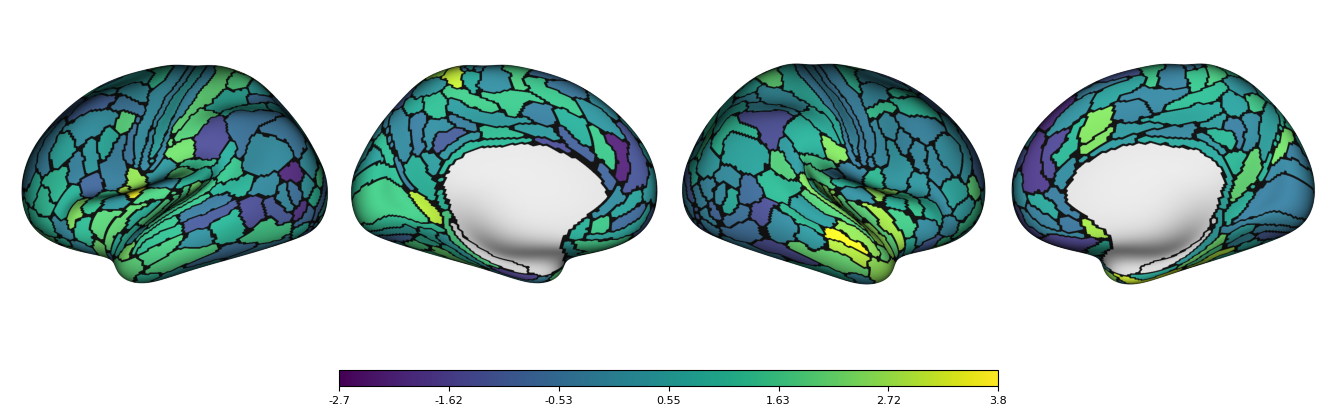

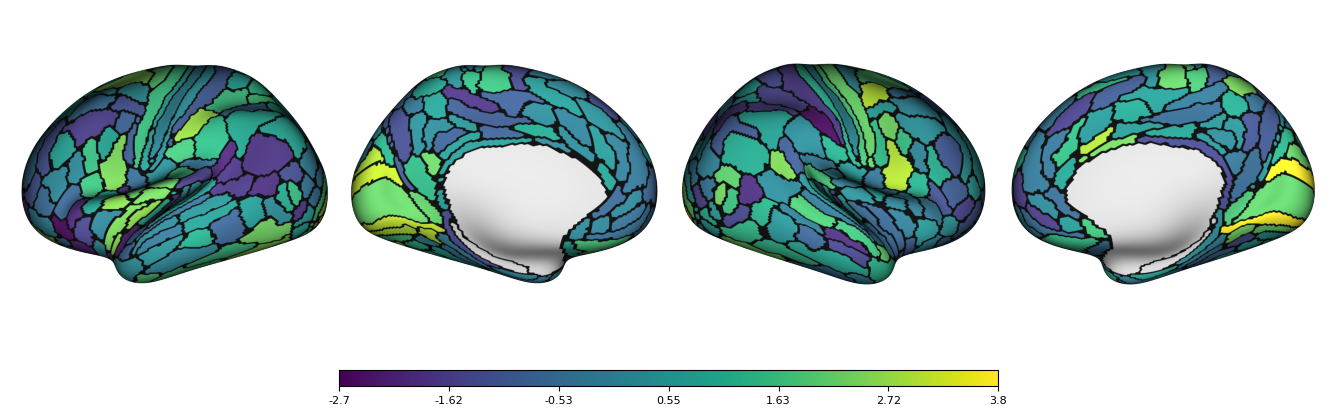

In [24]:
plot_maps('./results/ISC_Xloo_movie_tstat_{hemi}.shape.gii', (-2.7, 3.8))
plot_maps('./results/ISC_Xloo_rest_tstat_{hemi}.shape.gii', (-2.7, 3.8))

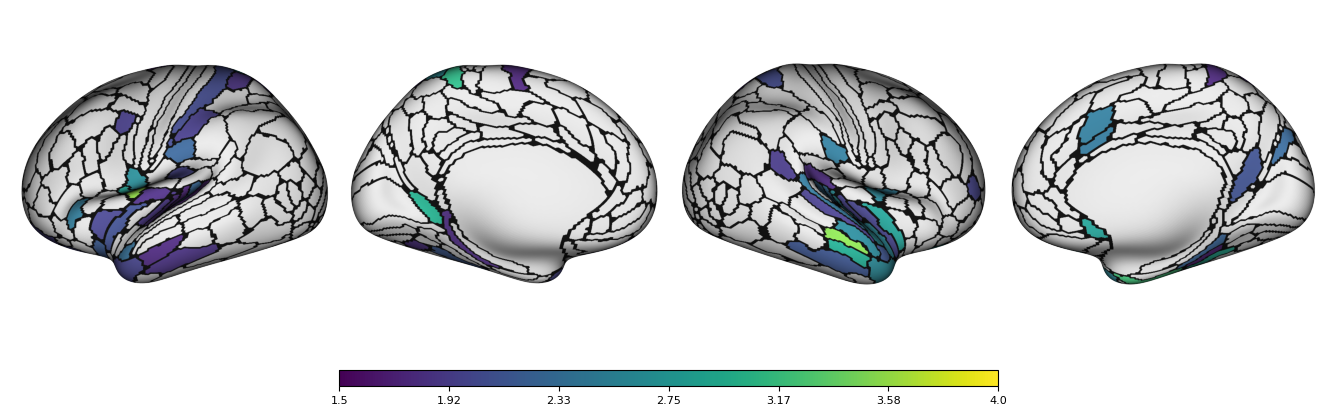

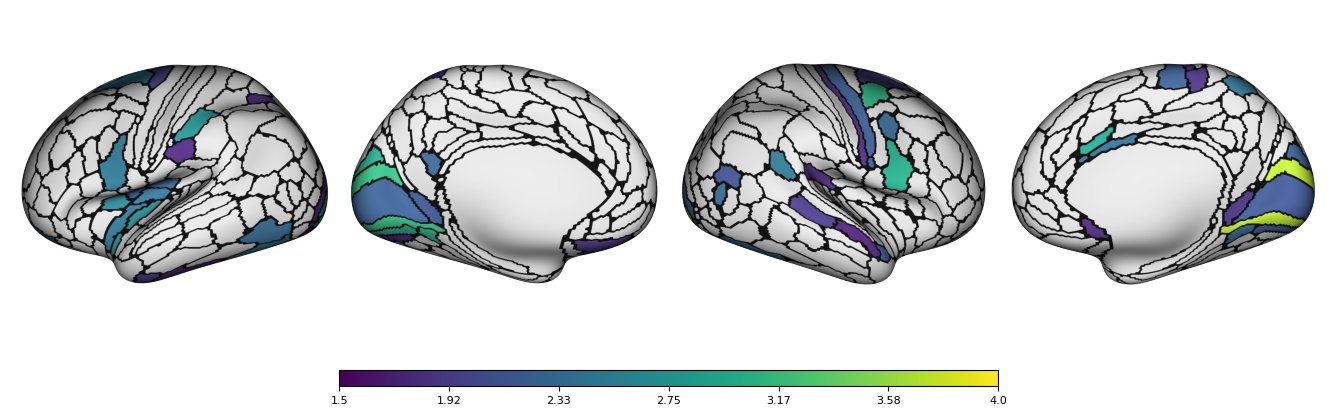

In [8]:
T_th_movie = dict()
T_th_rest = dict()
for h in ['L', 'R']:
    nonsig_mask = np.array(pval_movie[h])>0.05
    T_th_movie[h] = np.array(T_movie[h])
    T_th_movie[h][nonsig_mask] = 0

    nonsig_mask = np.array(pval_rest[h])>0.05
    T_th_rest[h] = np.array(T_rest[h])
    T_th_rest[h][nonsig_mask] = 0

roi2gii(T_th_movie, './results/', 'ISC_Xloo_movie_tstat_th')
roi2gii(T_th_rest, './results/', 'ISC_Xloo_rest_tstat_th')

plot_maps('./results/ISC_Xloo_movie_tstat_th_{hemi}.shape.gii', (1.5, 4))
plot_maps('./results/ISC_Xloo_rest_tstat_th_{hemi}.shape.gii', (1.5, 4))

## Pairwise ISC

In [10]:
ISC_movie_mixed = calculate_ISC(data_movie, range(0,n_subjects), method='pairwise-mixed', n_g1=n_patients)
ISC_rest_mixed = calculate_ISC(data_rest, range(0,n_subjects), method='pairwise-mixed', n_g1=n_patients)

/home/ali/anaconda3/envs/ISC-env/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ali/anaconda3/envs/ISC-env/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [29]:
def bootstrap_test(data1, data2, n_rep=10000):
    # boostrapping
    obs = data1.mean(axis=1)
    sample_size = data1.shape[1]

    dist = []
    for i in range(n_rep):
        # Generate n random indices. Assuming the number of columns is represented by matrix.shape[1]
        indices = np.random.choice(data2.shape[1], sample_size, replace=False)
        repetition_samples = np.array([row[indices] for row in data2],)
        dist.append(repetition_samples.mean(axis=1))

    dist = np.array(dist)
    p_val = np.sum(dist.T > obs.reshape((-1,1)), axis=1)/n_rep

    return p_val

In [30]:
p_val_movie = dict()
p_val_rest = dict()

for h in ['L', 'R']:
    print({'L':'left', 'R':'right'}[h])
    print('movie')
    p_val_movie[h] = bootstrap_test(ISC_movie_mixed[f'w_g2_{h}'], ISC_movie_mixed[f'b_{h}'])
    print('rest')
    p_val_rest[h] = bootstrap_test(ISC_rest_mixed[f'w_g2_{h}'], ISC_rest_mixed[f'b_{h}'])

left
movie
rest
right
movie
rest


In [32]:
diff_avg_movie = dict()
diff_avg_rest = dict()
for h in ['L', 'R']:
    diff_avg_movie[h] = ISC_movie_mixed[f'w_g2_{h}'].mean(axis=1) - ISC_movie_mixed[f'b_{h}'].mean(axis=1)
    diff_avg_movie[h][p_val_movie[h]>0.05] = 0
    diff_avg_rest[h] = ISC_rest_mixed[f'w_g2_{h}'].mean(axis=1) - ISC_rest_mixed[f'b_{h}'].mean(axis=1)
    diff_avg_rest[h][p_val_rest[h]>0.05] = 0

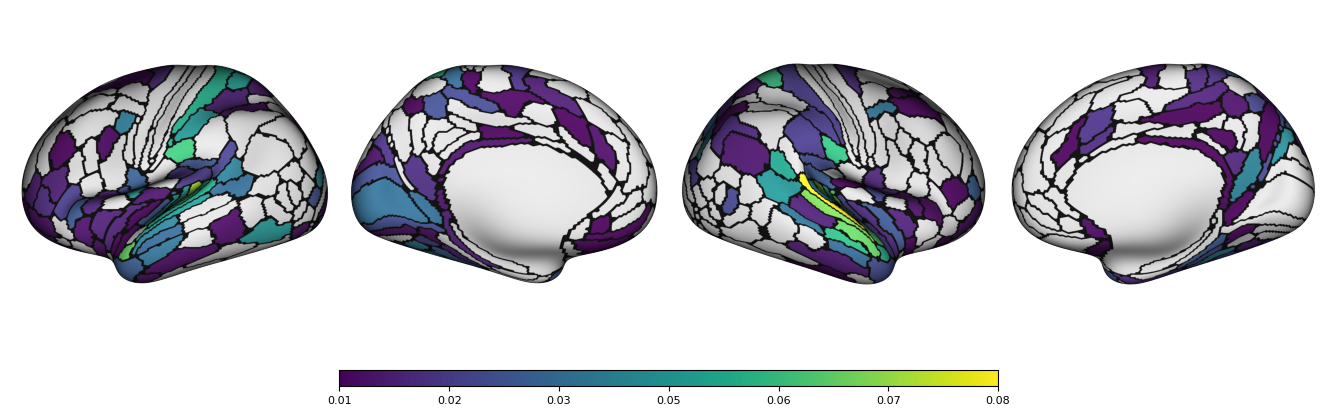

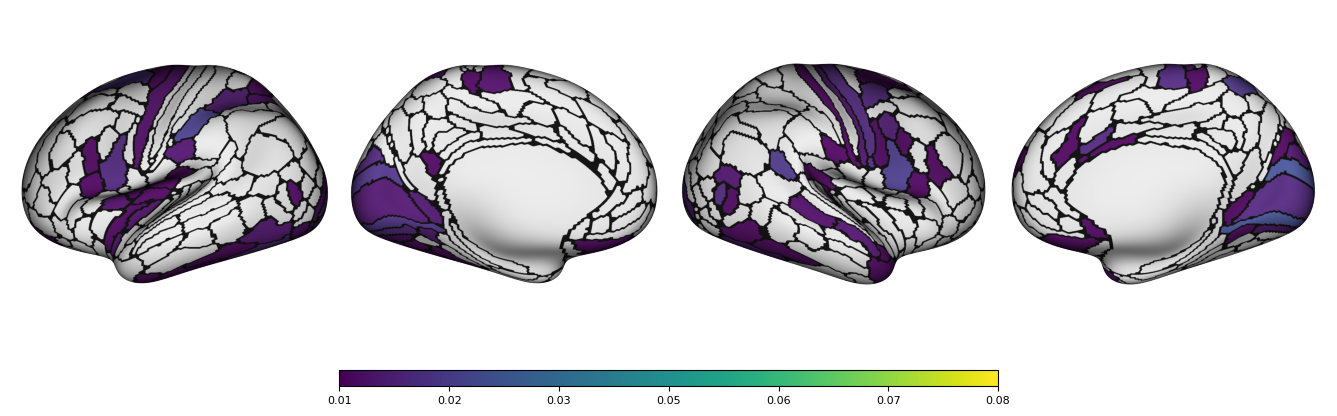

In [33]:
roi2gii(diff_avg_movie, './results', 'ISC_pairwise_mixed_movie')
roi2gii(diff_avg_rest, './results', 'ISC_pairwise_mixed_rest')

plot_maps("./results/ISC_pairwise_mixed_movie_{hemi}.shape.gii", (0.01, 0.08))
plot_maps("./results/ISC_pairwise_mixed_rest_{hemi}.shape.gii", (0.01, 0.08))

In [25]:
ISC_movie_p = calculate_ISC(data_movie, range(0,n_patients))
ISC_movie_c = calculate_ISC(data_movie, range(n_patients,n_subjects))
ISC_rest_p = calculate_ISC(data_rest, range(0,n_patients))
ISC_rest_c = calculate_ISC(data_rest, range(n_patients,n_subjects))

/home/ali/anaconda3/envs/ISC-env/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ali/anaconda3/envs/ISC-env/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


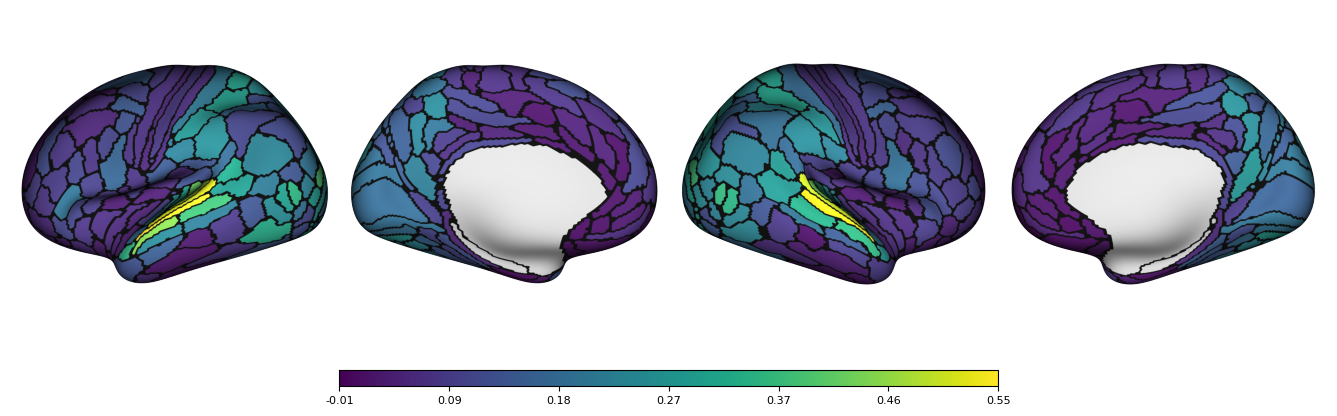

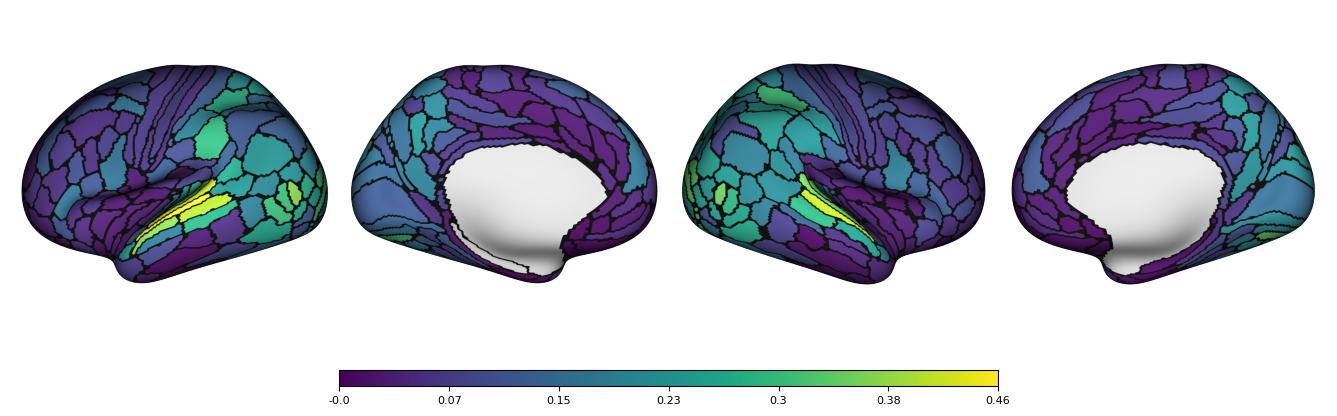

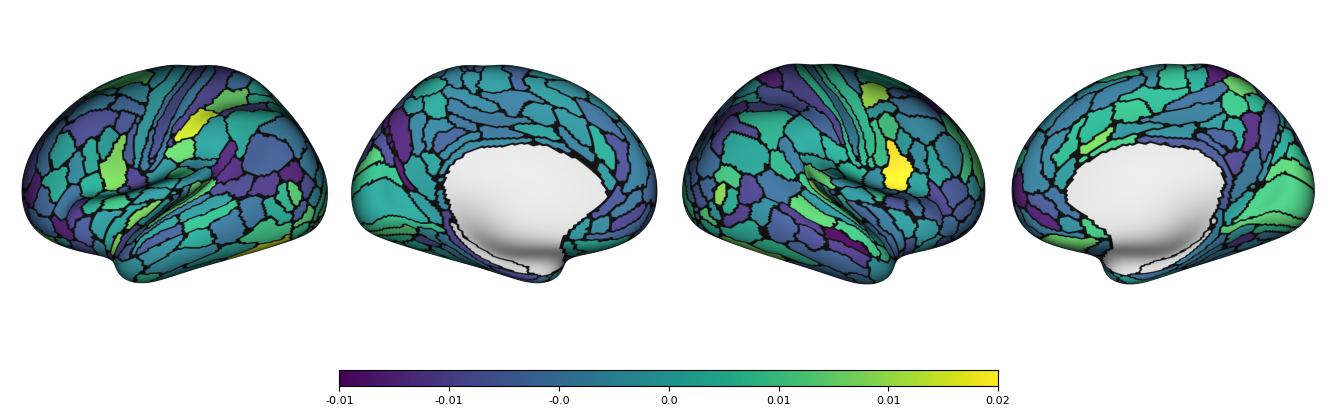

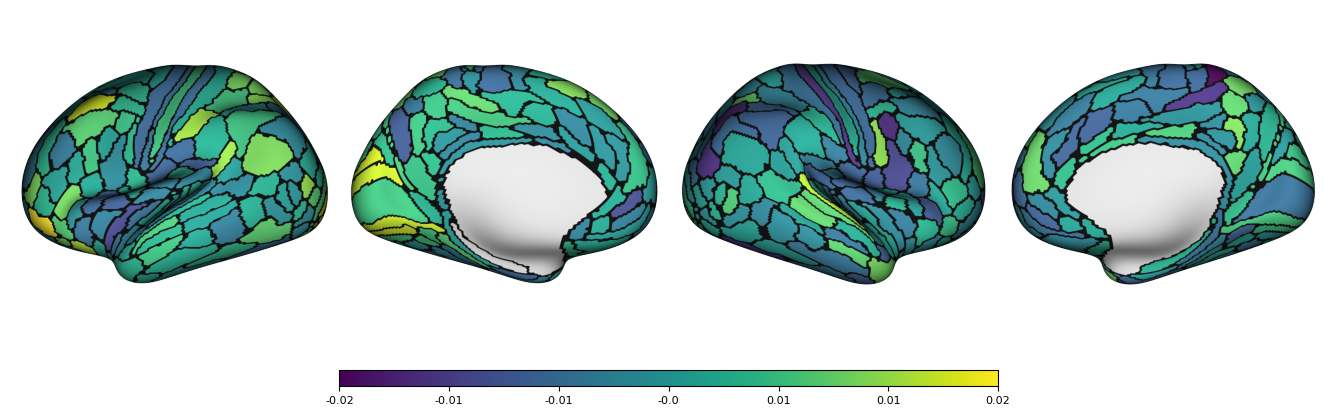

In [28]:
roi2gii(ISC_movie_p, './results', 'ISC_pairwise_mean_movie_patient')
roi2gii(ISC_movie_c, './results', 'ISC_pairwise_mean_movie_control')
roi2gii(ISC_rest_p, './results', 'ISC_pairwise_mean_rest_patient')
roi2gii(ISC_rest_c, './results', 'ISC_pairwise_mean_rest_control')

plot_maps("results/ISC_pairwise_mean_movie_control_{hemi}.shape.gii")
plot_maps("results/ISC_pairwise_mean_movie_patient_{hemi}.shape.gii")
plot_maps("results/ISC_pairwise_mean_rest_control_{hemi}.shape.gii")
plot_maps("results/ISC_pairwise_mean_rest_patient_{hemi}.shape.gii")